In [8]:
import sys
sys.path.append('/Users/abhigyakoirala/Standard-GP-is-all-you-need-for-HDBO/FinalMain/BayesOpt/')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings
from gpytorch.kernels import MaternKernel, ScaleKernel, RQKernel
import matplotlib as mpl
from BO_loop import BO_loop_GP, GP_Wrapper
from data import BayesOptDataset, FuncAckley
from sklearn.preprocessing import MinMaxScaler
import copy
from matplotlib.lines import Line2D

warnings.filterwarnings('ignore')

In [9]:
# Set random seeds
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

class FuncGriewank:
    def __init__(self, dim=1, maximize=False):
        self.dim = dim
        self.dims = dim  # For compatibility
        self.maximize = maximize
        
        # Bounds per dimension
        self.lb = np.full((dim,), -80.0)
        self.ub = np.full((dim,), 80.0)
        
        # MinMaxScaler expects 2D input
        self.inputs_scaler = MinMaxScaler()
        self.inputs_scaler.fit(np.vstack([self.lb, self.ub]))
        
        # Global minimum at origin
        self._opt_inputs = np.zeros((1, dim))

    def _scale_inputs(self, X):
        X = np.atleast_2d(X)
        assert X.shape[1] == self.dim, f"Expected input with {self.dim} dimensions, got {X.shape[1]}"
        return self.inputs_scaler.inverse_transform(X)

    def query(self, X):
        X = self._scale_inputs(X)
        term1 = np.sum(X**2, axis=1) / 4000
        term2 = np.prod(np.cos(X / np.sqrt(np.arange(1, self.dim + 1))), axis=1)
        result = (term1 - term2 + 1).reshape(-1, 1)
        return -result if self.maximize else result

    def get_opts(self):
        Xopts = self.inputs_scaler.transform(self._opt_inputs)
        yopts = self.query(Xopts)
        return Xopts, yopts

KERNEL_FLAGS = {
    "mat52": {"kernel": "mat52", "set_ls": False, "if_ard": False},
    "mat12": {"kernel": "mat12", "set_ls": False, "if_ard": False},
    "rq":    {"kernel": "rq",    "set_ls": False, "if_ard": False},
    "gcauchy": {"kernel": "gcauchy", "set_ls": False, "if_ard": False}
}


Cloning
[GP_Wrapper.step] 1000 epochs: 597.282084 → 1.301929 (Δ=595.980155, rel=99.78%)
[GP_Wrapper.step] 2000 epochs: 597.282084 → 1.292130 (Δ=595.989954, rel=99.78%)
Seed: 0 --- Kernel: mat52 --- itr: 11: best before=22.075058147052196, best after=22.075058147052196, curr query: [21.57031115], time=2.657s
Saved hyperparameters to /Users/abhigyakoirala/Standard-GP-is-all-you-need-for-HDBO/FinalMain/BayesOpt/hyperparams/Ackley/mat52/hyperparams_Ackley_mat52_seed0.csv
[GP_Wrapper.step] 50 epochs: 1.264141 → 1.257874 (Δ=0.006266, rel=0.50%)
[GP_Wrapper.step] 2000 epochs: 845.029544 → 1.243103 (Δ=843.786441, rel=99.85%)
Seed: 0 --- Kernel: mat52 --- itr: 12: best before=22.075058147052196, best after=22.075058147052196, curr query: [21.57031115], time=2.959s
Saved hyperparameters to /Users/abhigyakoirala/Standard-GP-is-all-you-need-for-HDBO/FinalMain/BayesOpt/hyperparams/Ackley/mat52/hyperparams_Ackley_mat52_seed0.csv
[GP_Wrapper.step] 50 epochs: 1.210314 → 1.209778 (Δ=0.000536, rel=0.04%

KeyboardInterrupt: 

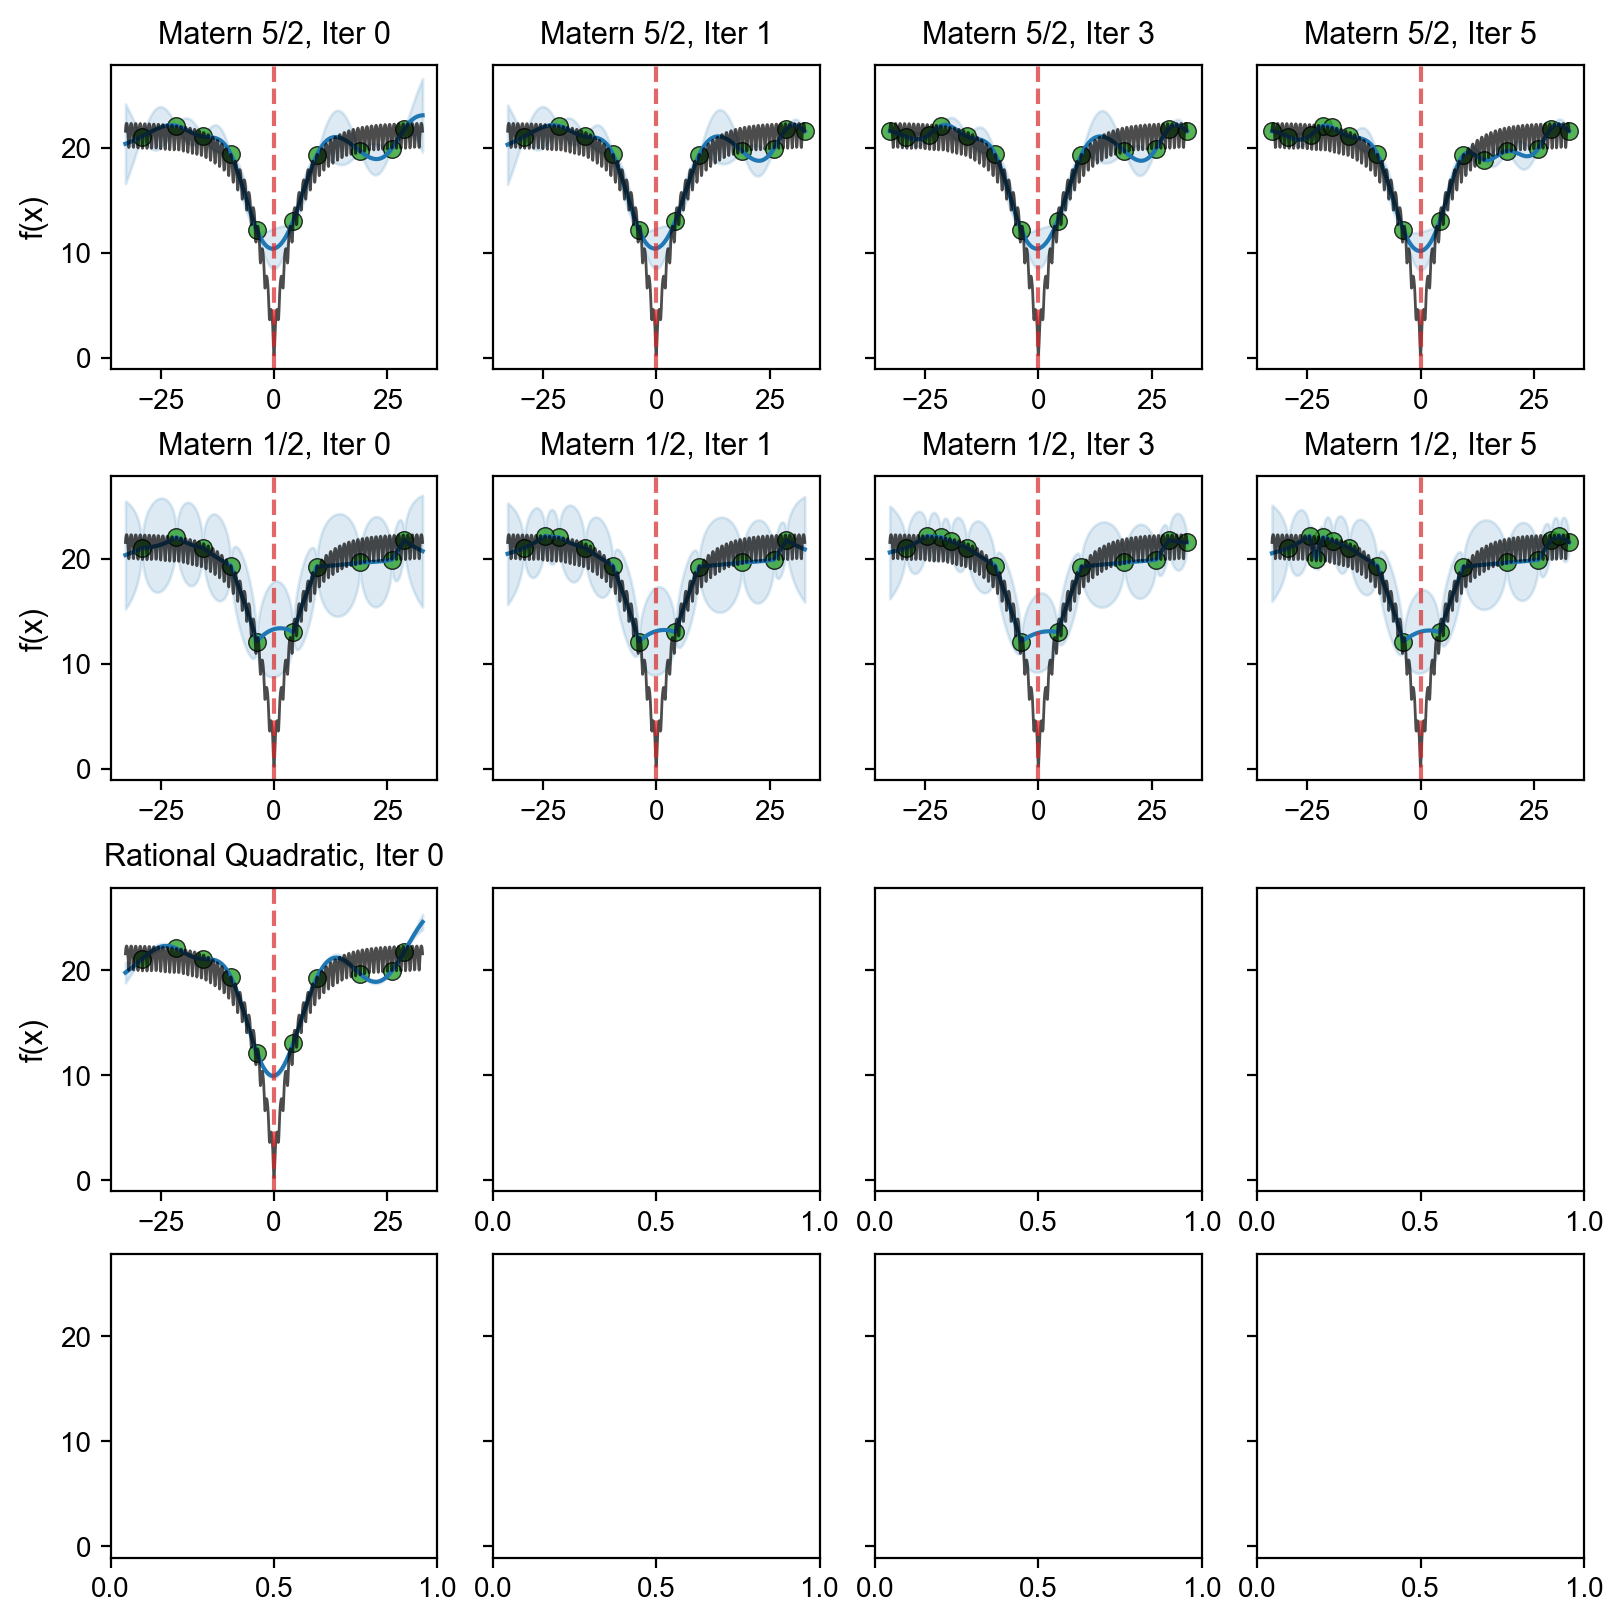

In [10]:
# Define consistent colors
colors_dict = {
    "gp_mean": "#1f77b4",       # blue
    "true_func": "#000000",     # black
    "samples": "#2ca02c",       # green
    "global_min": "#d62728",    # red
    "fill": "#1f77b4",          # same as gp_mean, but transparent
}

def save_best_values_csv(func_name, kernel_name, seed, best_values):
    """Save best objective values to CSV in the specified folder structure"""
    base_dir = "KRY"
    func_dir = os.path.join(base_dir, func_name)
    kernel_dir = os.path.join(func_dir, kernel_name)
    
    # Create directories if they don't exist
    os.makedirs(kernel_dir, exist_ok=True)
    
    # Create dataframe with iteration and best objective value
    iterations = list(range(len(best_values)))
    df = pd.DataFrame({
        'iteration': iterations,
        'best_obj_val': best_values
    })
    
    # Save to CSV
    filename = f"{func_name}_{kernel_name}_seed_{seed}.csv"
    filepath = os.path.join(kernel_dir, filename)
    df.to_csv(filepath, index=False)
    print(f"Saved: {filepath}")

def BO_UCB_plot_grid(kernel_types, kernel_names, dataset, total_iter=15, beta=1.5, func_name="Ackley"):
    # Configure plotting style
    mpl.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial','DejaVu Sans','Liberation Sans'],
        'font.size': 11,
        'axes.labelsize': 11,
        'axes.titlesize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 11
    })

    num_rows = len(kernel_types)
    num_cols = 4

    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        figsize=(8, 2 * num_rows),
        sharey=True,
        constrained_layout=True,
        dpi=200
    )

    # Get true function values for plotting
    x_true = np.linspace(0, 1, 800).reshape(-1, 1)
    y_true = dataset.func.query(x_true)

    for i, kernel_type in enumerate(kernel_types):
        current_dataset = dataset.clone()

        # Get kernel-specific flags
        flags = KERNEL_FLAGS[kernel_type]
        base_kern = flags["kernel"]
        set_ls = flags["set_ls"]
        if_ard = flags["if_ard"]

        # Initial state (iteration 0)
        X_init, Y_init = current_dataset.get_data(normalize=True)
        initial_best = torch.min(Y_init).item() if not dataset.func.maximize else torch.max(Y_init).item()

        # Create initial GP model
        gp_model = GP_Wrapper(
            X_init, Y_init,
            kernel=base_kern,
            if_ard=if_ard,
            if_softplus=True,
            set_ls=set_ls,
            device="cpu",
        )
        gp_model.init_optimizer(lr=0.1, optim="ADAM")
        gp_model.step(epochs=1000)  # long train once

        # Plot initial state
        plot_gp_state(
            axs[i, 0], gp_model, current_dataset, 0, kernel_names[i],
            x_true, y_true, is_first_col=True, is_last_row=(i == num_rows - 1)
        )

        # Define stages based on total_iter (1/3, 2/3, 3/3)
        stage1 = total_iter // 3
        stage2 = 2 * total_iter // 3
        stage3 = total_iter

        # Store best values for this kernel
        best_values = [initial_best]

        for j, n in enumerate([stage1, stage2, stage3], start=1):
            steps_to_run = n - [0, stage1, stage2][j - 1]
            
            # Run BO loop and capture best values
            new_best_values, _ = BO_loop_GP(
                func_name=func_name,
                dataset=current_dataset,
                seed=SEED,
                num_step=steps_to_run,
                beta=beta,
                if_ard=if_ard,
                if_softplus=True,
                acqf_type="UCB",
                set_ls=set_ls,
                kernel_type=base_kern,
                full_kernel_name=kernel_type,
                device="cpu"
            )
            
            # Append new best values (they start from the current best)
            best_values.extend(new_best_values)

            X, Y = current_dataset.get_data(normalize=True)
            gp_model.update_train_data(X, Y)
            gp_model.step(epochs=50)

            plot_gp_state(
                axs[i, j], gp_model, current_dataset, n, kernel_names[i],
                x_true, y_true, is_first_col=False, is_last_row=(i == num_rows - 1)
            )

        # Save CSV for this kernel
        save_best_values_csv(func_name, kernel_type, SEED, best_values)

    # Create unified legend
    custom_lines = [
        Line2D([0], [0], color=colors_dict["gp_mean"], lw=1.5, label='GP Mean'),
        Line2D([0], [0], color=colors_dict["true_func"], lw=1.0, label='True f(x)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_dict["samples"],
               markeredgecolor='k', markersize=6, label='Samples'),
        Line2D([0], [0], color=colors_dict["global_min"], linestyle='--', lw=1.5, label='Global Min'),
    ]

    fig.legend(custom_lines, [line.get_label() for line in custom_lines],
               loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05), frameon=False)

    plt.show()


def plot_gp_state(ax, gp, dataset, iteration, kernel_name, x_true, y_true, is_last_row, is_first_col):
    X_norm = dataset.X
    y_orig = dataset.y

    gp.gp_model.eval()
    gp.likelihood.eval()
    with torch.no_grad():
        posterior = gp.likelihood(gp.gp_model(torch.tensor(x_true)))

    mu_norm = posterior.mean.numpy()
    var_norm = posterior.variance.numpy()
    sigma_norm = np.sqrt(var_norm)

    y_mean = dataset.scaler.mean_[0]
    y_std = dataset.scaler.scale_[0]
    mu = mu_norm * y_std + y_mean
    sigma = sigma_norm * y_std

    # Only label on the first iteration (for legend handles)
    label_mu = "GP Mean" if iteration == 0 else None
    label_true = "True f(x)" if iteration == 0 else None
    label_samples = "Samples" if iteration == 0 else None
    label_min = "Global Min" if iteration == 0 else None

    ax.fill_between(dataset.func._scale_inputs(x_true).flatten(),
                    (mu - 1.96 * sigma).flatten(),
                    (mu + 1.96 * sigma).flatten(),
                    color=colors_dict["fill"], alpha=0.15)

    ax.plot(dataset.func._scale_inputs(x_true).flatten(), mu,
            color=colors_dict["gp_mean"], lw=1.5, label=label_mu)

    ax.plot(dataset.func._scale_inputs(x_true).flatten(), y_true,
            color=colors_dict["true_func"], lw=1.0, alpha=0.7, label=label_true)

    ax.scatter(dataset.func._scale_inputs(X_norm).flatten(), y_orig,
               c=[colors_dict["samples"]], s=40, alpha=0.8,
               edgecolors='k', linewidth=0.5, label=label_samples)

    ax.axvline(0, color=colors_dict["global_min"], linestyle='--',
               lw=1.5, alpha=0.7, label=label_min)

    ax.set_title(f"{kernel_name}, Iter {iteration}", pad=8)

    if is_last_row:
        ax.set_xlabel("x")
    if is_first_col:
        ax.set_ylabel("f(x)")


# Example usage
if __name__ == "__main__":
    #func = FuncGriewank(dim=1, maximize=False)
    func = FuncAckley(dim=1, maximize=False)
    dataset = BayesOptDataset(func, n_init=10, method='lhs', seed=SEED)

    kernel_types = ["mat52", "mat12", "rq", "gcauchy"]
    kernel_names = ["Matern 5/2", "Matern 1/2", "Rational Quadratic", "Generalized Cauchy"]

    BO_UCB_plot_grid(
        kernel_types=kernel_types,
        kernel_names=kernel_names,
        dataset=dataset,
        total_iter=5,
        beta=1.5,
        func_name="Ackley"  # Specify the function name so it doesnt get overwritten
    )